# Knowledge Distillation on CIFAR-10


In [1]:
# Standard imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [2]:
# CIFAR-10 dataset
batch_size = 128
num_workers = 4 if torch.cuda.is_available() else 0

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

data_dir = './data'
train_dataset = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform_test)

# Optionally split training into train/val
val_size = 5000
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

classes = train_dataset.dataset.classes if hasattr(train_dataset, 'dataset') else train_dataset.classes
print('Classes:', classes)
print('Train batches:', len(train_loader), 'Val batches:', len(val_loader), 'Test batches:', len(test_loader))


100%|██████████| 170M/170M [00:03<00:00, 46.9MB/s]


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Train batches: 352 Val batches: 40 Test batches: 79


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [3]:
# Define teacher model (ResNet18) - modify final layer for CIFAR-10
def get_teacher(num_classes=10, pretrained=False):
    teacher = models.resnet18(pretrained=pretrained)
    # Adjust first conv to CIFAR size if desired (optional). We'll keep it and rely on CIFAR->224 resize if using pretrained.
    # Replace final fully connected layer:
    teacher.fc = nn.Linear(teacher.fc.in_features, num_classes)
    return teacher

teacher = get_teacher(num_classes=10, pretrained=False).to(device)
print(teacher)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
# smaller student CNN
class StudentCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 16x16

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 8x8

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)  # 1x1
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

student = StudentCNN(num_classes=10).to(device)
print(student)


StudentCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): AdaptiveAvgPool2d(output_size=1)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=128, out_features=10, bias=True)

In [5]:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(loader, desc='Train', leave=False)
    for xb, yb in pbar:
        xb = xb.to(device); yb = yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
        _, predicted = preds.max(1)
        correct += (predicted == yb).sum().item()
        total += yb.size(0)
        pbar.set_postfix({'loss': running_loss/total, 'acc': correct/total})
    return running_loss / total, correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device); yb = yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            running_loss += loss.item() * xb.size(0)
            _, predicted = preds.max(1)
            correct += (predicted == yb).sum().item()
            total += yb.size(0)
    return running_loss/total, correct/total


In [6]:
# Train the teacher (or load pretrained state_dict if available)

teacher_path = './teacher_resnet18_cifar10.pth'
train_teacher = True  # set True to train teacher here

if train_teacher:
    epochs = 10
    optimizer = optim.SGD(teacher.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        tr_loss, tr_acc = train_epoch(teacher, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(teacher, val_loader, criterion, device)
        print(f"Epoch {epoch+1}: train_loss={tr_loss:.4f}, train_acc={tr_acc:.4f} | val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")
        scheduler.step()
    torch.save(teacher.state_dict(), teacher_path)
else:
    if os.path.exists(teacher_path):
        teacher.load_state_dict(torch.load(teacher_path, map_location=device))
        print('Loaded teacher from', teacher_path)
    else:
        print('No saved teacher found at', teacher_path, '\nYou can set train_teacher=True to train one.')

# Quick eval of teacher
criterion = nn.CrossEntropyLoss()
val_loss, val_acc = evaluate(teacher, val_loader, criterion, device)
print('Teacher val loss:', val_loss, 'val acc:', val_acc)


Epoch 1: train_loss=2.0916, train_acc=0.3077 | val_loss=1.5933, val_acc=0.4092


Epoch 2: train_loss=1.5150, train_acc=0.4442 | val_loss=1.4218, val_acc=0.4758


Epoch 3: train_loss=1.3223, train_acc=0.5256 | val_loss=1.3434, val_acc=0.5274


Epoch 4: train_loss=1.1814, train_acc=0.5794 | val_loss=1.2219, val_acc=0.5712


Epoch 5: train_loss=1.0748, train_acc=0.6162 | val_loss=1.0943, val_acc=0.6208


Epoch 6: train_loss=1.0104, train_acc=0.6446 | val_loss=1.1187, val_acc=0.6158


Epoch 7: train_loss=0.9554, train_acc=0.6634 | val_loss=1.0192, val_acc=0.6528


Epoch 8: train_loss=0.9138, train_acc=0.6810 | val_loss=0.9749, val_acc=0.6632


Epoch 9: train_loss=0.8755, train_acc=0.6950 | val_loss=0.9103, val_acc=0.6856


Epoch 10: train_loss=0.8605, train_acc=0.7006 | val_loss=1.0532, val_acc=0.6440
Teacher val loss: 1.0515188634872437 val acc: 0.6432


In [7]:
# Hinton et al., "Distilling the Knowledge in a Neural Network" (2015)
# https://arxiv.org/abs/1503.02531
# ------------------------------------------------------------
# loss = alpha * CE(student, hard_labels)
#       + (1 - alpha) * T^2 * KL(soft_student, soft_teacher)
# where:
#   soft_student = softmax(student / T)
#   soft_teacher = softmax(teacher / T)
# ============================================================

def kd_hinton_loss_fn(student_logits, teacher_logits, true_labels, temperature=4.0, alpha=0.5):
    # Cross-entropy with true labels
    ce_loss = F.cross_entropy(student_logits, true_labels)
    # Soft targets: KL divergence between softened probabilities
    p_student = F.log_softmax(student_logits / temperature, dim=1)
    p_teacher = F.softmax(teacher_logits / temperature, dim=1)
    kl_loss = F.kl_div(p_student, p_teacher, reduction='batchmean')
    loss = alpha * ce_loss + (1. - alpha) * (temperature ** 2) * kl_loss
    return loss, ce_loss, kl_loss


In [8]:
# Distillation training loop

def train_student_kd(student, teacher, train_loader, val_loader, epochs=20, lr=1e-3, temperature=4.0, alpha=0.5):
    teacher.eval()
    student.train()
    optimizer = optim.Adam(student.parameters(), lr=lr)
    best_val_acc = 0.0
    history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False)
        for xb, yb in pbar:
            xb = xb.to(device); yb = yb.to(device)
            optimizer.zero_grad()
            with torch.no_grad():
                teacher_logits = teacher(xb)
            student_logits = student(xb)
            loss, ce, kl = kd_hinton_loss_fn(student_logits, teacher_logits, yb, temperature=temperature, alpha=alpha)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * xb.size(0)
            _, predicted = student_logits.max(1)
            correct += (predicted == yb).sum().item()
            total += yb.size(0)
            pbar.set_postfix({'loss': running_loss/total, 'acc': correct/total})
        train_loss = running_loss / total
        train_acc = correct / total
        val_loss, val_acc = evaluate(student, val_loader, nn.CrossEntropyLoss(), device)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f} | val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")
        # Save best
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(student.state_dict(), 'student_kd_best.pth')
    print('Best val acc:', best_val_acc)
    return history


In [9]:
# Example hook setup:
teacher_features, student_features = {}, {}

def get_activation(name, storage):
    def hook(model, input, output):
        storage[name] = output
    return hook

# Register on a specific layer
teacher.layer4.register_forward_hook(get_activation('t_feat', teacher_features))
student.features[-2].register_forward_hook(get_activation('s_feat', student_features))


Epoch 1: train_loss=1.5638, train_acc=0.4054 | val_loss=1.4334, val_acc=0.4834


Epoch 2: train_loss=1.5904, train_acc=0.4029 | val_loss=1.4371, val_acc=0.4902


Epoch 3: train_loss=1.2340, train_acc=0.5032 | val_loss=1.3602, val_acc=0.5176


Epoch 4: train_loss=1.1275, train_acc=0.5320 | val_loss=1.2817, val_acc=0.5452


Epoch 5: train_loss=1.0667, train_acc=0.5528 | val_loss=1.1928, val_acc=0.5736


Epoch 6: train_loss=1.0171, train_acc=0.5675 | val_loss=1.1980, val_acc=0.5794


Epoch 7: train_loss=0.9753, train_acc=0.5840 | val_loss=1.1740, val_acc=0.5888


Epoch 8: train_loss=0.9279, train_acc=0.5968 | val_loss=1.1096, val_acc=0.6034


Epoch 9: train_loss=0.8942, train_acc=0.6082 | val_loss=1.0496, val_acc=0.6270


Epoch 10: train_loss=0.8592, train_acc=0.6223 | val_loss=1.0500, val_acc=0.6310


Epoch 11: train_loss=0.8383, train_acc=0.6350 | val_loss=1.0469, val_acc=0.6322


Epoch 12: train_loss=0.8096, train_acc=0.6423 | val_loss=0.9978, val_acc=0.6502


Epoch 13: train_loss=0.7814, train_acc=0.6534 | val_loss=1.0029, val_acc=0.6474


Epoch 14: train_loss=0.7586, train_acc=0.6635 | val_loss=0.9528, val_acc=0.6744


Epoch 15: train_loss=0.7413, train_acc=0.6711 | val_loss=0.9686, val_acc=0.6688


Epoch 16: train_loss=0.7224, train_acc=0.6782 | val_loss=0.9236, val_acc=0.6862


Epoch 17: train_loss=0.7052, train_acc=0.6852 | val_loss=0.9288, val_acc=0.6776


Epoch 18: train_loss=0.6953, train_acc=0.6912 | val_loss=0.8842, val_acc=0.6954


Epoch 19: train_loss=0.6827, train_acc=0.6993 | val_loss=0.9192, val_acc=0.6832


Epoch 20: train_loss=0.6689, train_acc=0.7044 | val_loss=0.8856, val_acc=0.6984
Best val acc: 0.6984


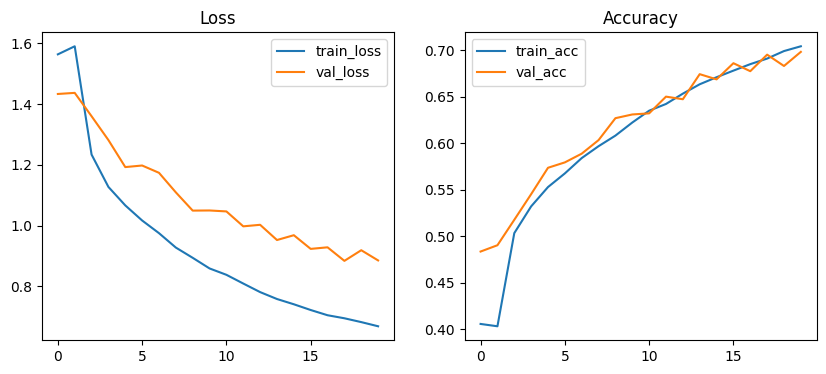

In [10]:
# Run distillation (set run_kd=True to perform training)
run_kd = True
if run_kd:
    # Optionally load a teacher checkpoint if not already loaded
    history = train_student_kd(student, teacher, train_loader, val_loader, epochs=20, lr=1e-3, temperature=4.0, alpha=0.5)
    # Plot training curves
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history['train_loss'], label='train_loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.legend()
    plt.title('Loss')
    plt.subplot(1,2,2)
    plt.plot(history['train_acc'], label='train_acc')
    plt.plot(history['val_acc'], label='val_acc')
    plt.legend()
    plt.title('Accuracy')
else:
    print('Set run_kd=True to train the student with knowledge distillation.')


Loaded student from student_kd_best.pth
Student test loss: 0.8769985327720642 test acc: 0.6961


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


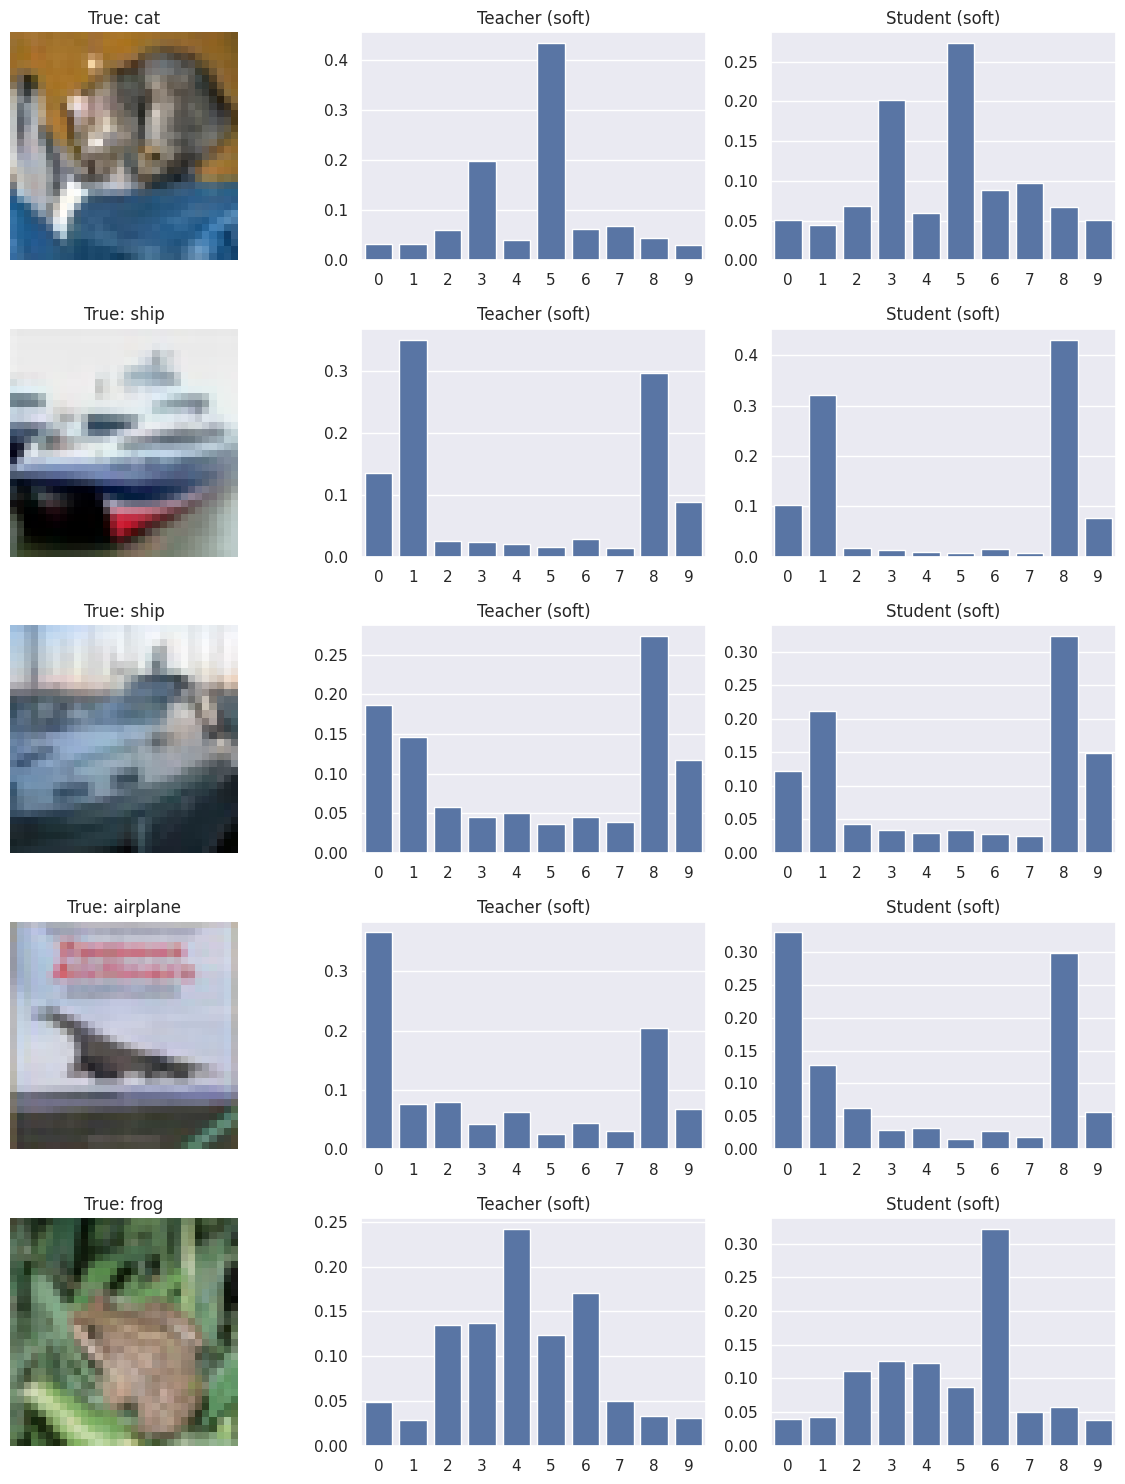

In [11]:
# Evaluate student (load best checkpoint if present)
student_path = 'student_kd_best.pth'
if os.path.exists(student_path):
    student.load_state_dict(torch.load(student_path, map_location=device))
    print('Loaded student from', student_path)
else:
    print('No student checkpoint found at', student_path)

criterion = nn.CrossEntropyLoss()
test_loss, test_acc = evaluate(student, test_loader, criterion, device)
print('Student test loss:', test_loss, 'test acc:', test_acc)

# Visualize some predictions and teacher vs student soft logits for a few samples
import seaborn as sns
sns.set()

def visualize_logits(student, teacher, loader, n=5, temperature=4.0):
    student.eval(); teacher.eval()
    images = []
    student_probs = []
    teacher_probs = []
    labels = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device); yb = yb.to(device)
            t_logits = teacher(xb)
            s_logits = student(xb)
            t_ps = F.softmax(t_logits / temperature, dim=1).cpu().numpy()
            s_ps = F.softmax(s_logits / temperature, dim=1).cpu().numpy()
            for i in range(min(n, xb.size(0))):
                images.append(xb[i].cpu())
                teacher_probs.append(t_ps[i])
                student_probs.append(s_ps[i])
                labels.append(yb[i].cpu().item())
            break
    # Plot images + barplots
    plt.figure(figsize=(12, 3*n))
    for i in range(n):
        ax = plt.subplot(n, 3, i*3 + 1)
        img = images[i]
        # unnormalize
        img = img * torch.tensor((0.247,0.243,0.261)).view(3,1,1) + torch.tensor((0.4914,0.4822,0.4465)).view(3,1,1)
        npimg = np.clip(img.permute(1,2,0).numpy(), 0, 1)
        ax.imshow(npimg)
        ax.set_title(f'True: {classes[labels[i]]}')
        ax.axis('off')

        ax2 = plt.subplot(n, 3, i*3 + 2)
        sns.barplot(x=list(range(len(teacher_probs[i]))), y=teacher_probs[i])
        ax2.set_title('Teacher (soft)')

        ax3 = plt.subplot(n, 3, i*3 + 3)
        sns.barplot(x=list(range(len(student_probs[i]))), y=student_probs[i])
        ax3.set_title('Student (soft)')
    plt.tight_layout()

# Visualize first batch from test loader
visualize_logits(student, teacher, test_loader, n=5, temperature=4.0)


# Задание на семинар

Реализовать 3 из лоссов ниже и попробовать дистиллировать предобученную модель (можно использовать свои вариации teacher и student моделей, вместо предложенных в семинаре). Нужно привести таблицу сравнения качества 2 выбранных лоссов и классического Hinton лосса.

In [12]:
# FitNets (Romero et al., "FitNets: Hints for Thin Deep Nets", 2015)
# https://arxiv.org/abs/1412.6550
# ------------------------------------------------------------
# loss = alpha * KD_loss
#       + beta * MSE(student_feature, teacher_feature)
# ============================================================


import torch.nn.functional as F

def fitnet_loss(student_logits, teacher_logits, student_feat, teacher_feat,
                targets, T=4.0, alpha=0.5, beta=50.0):
    """
    student_logits, teacher_logits: [B, num_classes]
    student_feat, teacher_feat: фичи из хуков, обычно [B, C, H, W]
    targets: [B]
    T: temperature (температура для KD)
    alpha: вес CE (как в Hinton KD)
    beta: вес фич-лосса (FitNet часть)
    """

    kd_loss, ce_loss, kl_loss = kd_hinton_loss_fn(
        student_logits, teacher_logits, targets,
        temperature=T,
        alpha=alpha
    )

    assert student_feat is not None and teacher_feat is not None, \
        "Hooks для фичей не сработали: проверь регистрацию forward_hook"

    s = student_feat
    t = teacher_feat.detach()

    if s.dim() == 4:
        s = s.pow(2).mean(dim=1, keepdim=True)
        t = t.pow(2).mean(dim=1, keepdim=True)

        target_hw = (4, 4)
        s = F.adaptive_avg_pool2d(s, target_hw)
        t = F.adaptive_avg_pool2d(t, target_hw)

        s = s.view(s.size(0), -1)
        t = t.view(t.size(0), -1)
    else:
        s = s.view(s.size(0), -1)
        t = t.view(t.size(0), -1)
        d = min(s.size(1), t.size(1))
        s = s[:, :d]
        t = t[:, :d]

    feat_loss = F.mse_loss(s, t)

    total_loss = kd_loss + beta * feat_loss
    return total_loss



In [13]:
# Attention Transfer (Zagoruyko & Komodakis, 2017)
# https://arxiv.org/abs/1612.03928
# ------------------------------------------------------------
# Symbols:
#   F_t : teacher feature map  [B, C, H, W]
#   F_s : student feature map  [B, C, H, W]
#   mean_c : mean in channel dim
#
# ------------------------------------------------------------
# Full formula:
#     L_AT = || Normalize( mean_c(F_s^2) ) - Normalize( mean_c(F_t^2) ) ||_2^2
# ============================================================


def at_loss(student_feat, teacher_feat, eps=1e-8):
    F_s = student_feat
    F_t = teacher_feat.detach()

    def attention_map(F_):
        am = F_.pow(2).mean(dim=1)
        am = am.view(am.size(0), -1)
        am = am / (am.norm(p=2, dim=1, keepdim=True) + eps)
        return am

    A_s = attention_map(F_s)
    A_t = attention_map(F_t)

    return F.mse_loss(A_s, A_t)


In [14]:
# Relational Knowledge Distillation (Park et al., 2019)
# https://arxiv.org/abs/1904.05068
# ------------------------------------------------------------
# loss = distance_loss + angle_loss
# where:
#   distance_loss = SmoothL1(pairwise_distance(student), pairwise_distance(teacher))
#   angle_loss    = SmoothL1(pairwise_angle(student), pairwise_angle(teacher))
# ============================================================


def rkd_loss(student_feat, teacher_feat, eps=1e-8, w_dist=1.0, w_angle=2.0):
    """
    student_feat, teacher_feat: [B, D] или [B, C, H, W]
    Возвращает: total, dist_loss, angle_loss
    """
    s = student_feat.view(student_feat.size(0), -1)
    t = teacher_feat.detach().view(teacher_feat.size(0), -1)
    B = s.size(0)
    if B < 2:
        zero = torch.tensor(0.0, device=s.device)
        return zero, zero, zero

    def pairwise_distance(x):
        dist = torch.cdist(x, x, p=2)
        mask = (dist > 0).detach()
        mean_dist = dist[mask].mean()
        dist = dist / (mean_dist + eps)
        return dist

    dist_s = pairwise_distance(s)
    dist_t = pairwise_distance(t)
    dist_loss = F.smooth_l1_loss(dist_s, dist_t)

    def pairwise_angle(x):
        diff = x.unsqueeze(0) - x.unsqueeze(1)
        norm = torch.norm(diff, p=2, dim=2, keepdim=True)
        diff = diff / (norm + eps)
        angle = torch.matmul(diff, diff.transpose(1, 2))
        return angle

    angle_s = pairwise_angle(s)
    angle_t = pairwise_angle(t)
    angle_loss = F.smooth_l1_loss(angle_s, angle_t)

    total = w_dist * dist_loss + w_angle * angle_loss
    return total, dist_loss, angle_loss


In [33]:
# Contrastive Representation Distillation (Tian et al., 2020)
# https://arxiv.org/abs/1910.10699
# ------------------------------------------------------------
# Symbols:
#   s_i  -> feature vector from student for sample i
#   t_i  -> corresponding feature vector from teacher for sample i
#   t_j  -> teacher features of *other* samples (negatives)
#   τ (tau) -> temperature scaling factor for softmax sharpness
#
# Formula:
#   loss = -log( exp(sim(s_i, t_i)/τ) / sum_j exp(sim(s_i, t_j)/τ) )
#
# Where:
#   sim(a, b) = cosine_similarity(a, b)
# ============================================================


def crd_loss(student_feat, teacher_feat, temperature=0.07):
    """
    student_feat, teacher_feat: [B, D] или [B, C, H, W]
    """
    s = student_feat.view(student_feat.size(0), -1)
    t = teacher_feat.detach().view(teacher_feat.size(0), -1)

    s = F.normalize(s, p=2, dim=1)
    t = F.normalize(t, p=2, dim=1)

    logits = torch.matmul(s, t.t()) / temperature
    targets = torch.arange(logits.size(0), device=logits.device)

    loss = F.cross_entropy(logits, targets)
    return loss


In [16]:
# Decoupled Knowledge Distillation (Zhao et al., CVPR 2022)
# https://arxiv.org/abs/2203.08679
# ------------------------------------------------------------
# Symbols:
#   p_t = teacher's softmax probabilities (teacher predictions)
#   p_s = student's softmax probabilities (student predictions)
#   y_true = ground truth class index
#   p_t_pos = teacher's predicted probability for the correct class
#   p_t_neg = sum of teacher probabilities for all *other* classes
#   log_s_pos = log of student's predicted prob for correct class
#   log_s_neg = log of student's total prob for all *other* classes
#
# Formula:
#   loss_target     = - (T^2) * mean(p_t_pos * log(p_s_pos))
#   loss_non_target = - (T^2) * mean(p_t_neg * log(p_s_neg))
#   total_loss = α * loss_target + β * loss_non_target
#
# Notes:
#   - T = temperature (same concept as in classic KD)
#   - α, β = balance weights between the two parts
# ============================================================


def dkd_loss(student_logits, teacher_logits, targets, alpha=1.0, beta=8.0, T=4.0, eps=1e-8):
    p_t = F.softmax(teacher_logits / T, dim=1).detach()
    p_s = F.softmax(student_logits / T, dim=1)

    idx = targets.view(-1, 1)
    p_t_pos = p_t.gather(1, idx).squeeze(1)
    p_s_pos = p_s.gather(1, idx).squeeze(1)

    p_t_neg = 1.0 - p_t_pos
    p_s_neg = 1.0 - p_s_pos

    log_p_s_pos = torch.log(p_s_pos + eps)
    log_p_s_neg = torch.log(p_s_neg + eps)

    loss_target     = - (T**2) * (p_t_pos * log_p_s_pos).mean()
    loss_non_target = - (T**2) * (p_t_neg * log_p_s_neg).mean()

    total = alpha * loss_target + beta * loss_non_target
    return total



In [34]:
import copy
import pandas as pd

def get_new_student():
    """Создаём нового студента для каждого эксперимента."""
    return StudentCNN(num_classes=10).to(device)


def train_student_with_method(
    method_name,
    teacher,
    train_loader,
    val_loader,
    test_loader,
    epochs=20,
    lr=1e-3,
    T=4.0,
    alpha_hinton=0.5,
    beta_fit=50.0,
    alpha_dkd=1.0,
    beta_dkd=8.0,
):
    """
    Обучение студента с выбранным методом дистилляции.
    Возвращает (best_val_acc, test_acc).
    """

    teacher.eval()
    student = get_new_student()
    optimizer = optim.Adam(student.parameters(), lr=lr)

    teacher_features, student_features = {}, {}

    def get_activation(name, storage):
        def hook(model, input, output):
            storage[name] = output
        return hook

    teacher_handle = teacher.layer4.register_forward_hook(
        get_activation('t_feat', teacher_features)
    )
    student_handle = student.features[-2].register_forward_hook(
        get_activation('s_feat', student_features)
    )

    best_val_acc = 0.0
    best_state = None

    for epoch in range(epochs):
        student.train()
        running_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(train_loader, desc=f'{method_name} epoch {epoch+1}/{epochs}', leave=False)
        for xb, yb in pbar:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()

            with torch.no_grad():
                t_logits = teacher(xb)
                t_feat = teacher_features.get('t_feat', None)

            s_logits = student(xb)
            s_feat = student_features.get('s_feat', None)

            if method_name == 'hinton':
                loss, ce_loss, kl_loss = kd_hinton_loss_fn(
                    s_logits, t_logits, yb,
                    temperature=T,
                    alpha=alpha_hinton,
                )

            elif method_name == 'fitnet':
                loss = fitnet_loss(
                    s_logits, t_logits,
                    s_feat, t_feat,
                    yb, T=T, alpha=alpha_hinton, beta=beta_fit,
                )

            elif method_name == 'crd':
                # ce = F.cross_entropy(s_logits, yb)

                # # 2) CRD по фичам
                # crd = crd_loss(s_feat, t_feat, temperature=0.1)

                # # 3) суммарный лосс
                # lambda_crd = 0.1   # можно начать с 0.05–0.1
                # loss = ce + lambda_crd * crd
                loss = crd_loss(
                    s_logits, t_logits
                )

            elif method_name == 'at':
                loss = at_loss(
                    s_logits, t_logits
                )


            else:
                raise ValueError(f'Unknown method_name={method_name}')

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * xb.size(0)
            preds = s_logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

            pbar.set_postfix({'loss': running_loss / total,
                              'acc': correct / total})

        train_loss = running_loss / total
        train_acc = correct / total

        val_loss, val_acc = evaluate(student, val_loader, nn.CrossEntropyLoss(), device)
        print(f"[{method_name}] Epoch {epoch+1}: "
              f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f} | "
              f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = copy.deepcopy(student.state_dict())

    teacher_handle.remove()
    student_handle.remove()

    if best_state is not None:
        student.load_state_dict(best_state)
    test_loss, test_acc = evaluate(student, test_loader, nn.CrossEntropyLoss(), device)

    print(f"[{method_name}] Best val_acc={best_val_acc:.4f}, test_acc={test_acc:.4f}")
    return best_val_acc, test_acc


In [31]:
methods_to_run = ['at', 'fitnet', 'hinton']
results = []

for method in methods_to_run:
    print(f"\n=== Training student with {method} KD ===")
    val_acc, test_acc = train_student_with_method(
        method_name=method,
        teacher=teacher,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        epochs=10,
        lr=1e-3,
        T=4.0,
    )
    results.append({
        'method': method,
        'val_acc': val_acc,
        'test_acc': test_acc,
    })

results_df = pd.DataFrame(results)
print("\n=== KD methods comparison ===")
print(results_df)



=== Training student with at KD ===


at epoch 1/10:   0%|          | 0/352 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


KeyboardInterrupt: 

In [35]:
methods_to_run = ['crd', 'fitnet', 'hinton']
results = []

for method in methods_to_run:
    print(f"\n=== Training student with {method} KD ===")
    val_acc, test_acc = train_student_with_method(
        method_name=method,
        teacher=teacher,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        epochs=10,
        lr=1e-3,
        T=4.0,
    )
    results.append({
        'method': method,
        'val_acc': val_acc,
        'test_acc': test_acc,
    })

results_df = pd.DataFrame(results)
print("\n=== KD methods comparison ===")
print(results_df)



=== Training student with crd KD ===


[crd] Epoch 1: train_loss=3.4792, train_acc=0.3351 | val_loss=1.9415, val_acc=0.3826


[crd] Epoch 2: train_loss=2.7060, train_acc=0.4352 | val_loss=1.9278, val_acc=0.4512


[crd] Epoch 3: train_loss=2.4916, train_acc=0.4698 | val_loss=1.9162, val_acc=0.5084


[crd] Epoch 4: train_loss=2.3634, train_acc=0.4848 | val_loss=1.9020, val_acc=0.5192


[crd] Epoch 5: train_loss=2.2680, train_acc=0.4996 | val_loss=1.9348, val_acc=0.5044


[crd] Epoch 6: train_loss=2.1925, train_acc=0.5098 | val_loss=1.9315, val_acc=0.5430


[crd] Epoch 7: train_loss=2.1231, train_acc=0.5182 | val_loss=1.9518, val_acc=0.5234


[crd] Epoch 8: train_loss=2.0793, train_acc=0.5306 | val_loss=1.9847, val_acc=0.5214


[crd] Epoch 9: train_loss=2.0233, train_acc=0.5390 | val_loss=2.0066, val_acc=0.5252


[crd] Epoch 10: train_loss=1.9969, train_acc=0.5433 | val_loss=2.0286, val_acc=0.5686
[crd] Best val_acc=0.5686, test_acc=0.5609

=== Training student with fitnet KD ===


[fitnet] Epoch 1: train_loss=2.9167, train_acc=0.2148 | val_loss=1.7375, val_acc=0.3006


[fitnet] Epoch 2: train_loss=1.7307, train_acc=0.3529 | val_loss=1.6190, val_acc=0.3722


[fitnet] Epoch 3: train_loss=1.4920, train_acc=0.4252 | val_loss=1.6086, val_acc=0.4190


[fitnet] Epoch 4: train_loss=1.3313, train_acc=0.4805 | val_loss=1.4381, val_acc=0.4738


[fitnet] Epoch 5: train_loss=1.2355, train_acc=0.5153 | val_loss=1.3350, val_acc=0.5266


[fitnet] Epoch 6: train_loss=1.1606, train_acc=0.5419 | val_loss=1.3210, val_acc=0.5186


[fitnet] Epoch 7: train_loss=1.1084, train_acc=0.5604 | val_loss=1.2014, val_acc=0.5544


[fitnet] Epoch 8: train_loss=1.0640, train_acc=0.5750 | val_loss=1.1534, val_acc=0.5890


[fitnet] Epoch 9: train_loss=1.0257, train_acc=0.5889 | val_loss=1.0872, val_acc=0.6146


[fitnet] Epoch 10: train_loss=0.9989, train_acc=0.5984 | val_loss=1.0727, val_acc=0.6170
[fitnet] Best val_acc=0.6170, test_acc=0.6139

=== Training student with hinton KD ===


[hinton] Epoch 1: train_loss=1.5819, train_acc=0.3912 | val_loss=1.4447, val_acc=0.4682


[hinton] Epoch 2: train_loss=1.2183, train_acc=0.5031 | val_loss=1.3550, val_acc=0.5102


[hinton] Epoch 3: train_loss=1.1054, train_acc=0.5452 | val_loss=1.2454, val_acc=0.5454


[hinton] Epoch 4: train_loss=1.0442, train_acc=0.5672 | val_loss=1.2729, val_acc=0.5452


[hinton] Epoch 5: train_loss=1.0067, train_acc=0.5816 | val_loss=1.1454, val_acc=0.5894


[hinton] Epoch 6: train_loss=0.9690, train_acc=0.5992 | val_loss=1.1699, val_acc=0.5720


[hinton] Epoch 7: train_loss=0.9425, train_acc=0.6057 | val_loss=1.0942, val_acc=0.6192


[hinton] Epoch 8: train_loss=0.9190, train_acc=0.6164 | val_loss=1.2070, val_acc=0.5528


[hinton] Epoch 9: train_loss=0.9022, train_acc=0.6258 | val_loss=1.0768, val_acc=0.6336


[hinton] Epoch 10: train_loss=0.8810, train_acc=0.6337 | val_loss=1.2437, val_acc=0.5664
[hinton] Best val_acc=0.6336, test_acc=0.6180

=== KD methods comparison ===
   method  val_acc  test_acc
0     crd   0.5686    0.5609
1  fitnet   0.6170    0.6139
2  hinton   0.6336    0.6180
